In [13]:
from typing import Dict, List, Tuple
import numpy as np
import torch.nn.functional as F
import torch.nn as nn
import torch
import scipy
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
import random

In [14]:
INPUT = "input3.txt"
OUTPUT = "output.txt"

In [15]:
class GridWorld:
    class Object:
        def __init__(self, object_positions, world):
            self.world = world
            self.positions = object_positions

            self.pivot_low = (self.world.height, self.world.width)
            self.pivot_hight = (0,0)

            for part in self.positions:
                x, y = part
                if x >= self.pivot_hight[0] and y >= self.pivot_hight[1]:
                    self.pivot_hight = (x, y)
                if x <= self.pivot_low[0] and y <= self.pivot_low[1]:
                    self.pivot_low = (x, y)

            self.initial_positions = self.positions
            self.initial_pivot_low = self.pivot_low 
            self.initial_pivot_hight = self.pivot_hight 

        def reset(self):
            self.positions = self.initial_positions  
            self.pivot_low = self.initial_pivot_low 
            self.pivot_hight = self.initial_pivot_hight

        def possible_action(self, deltaX, deltaY):
            for x, y in self.positions:
                if x+deltaX >= self.world.height or x+deltaX < 0 or y+deltaY >= self.world.width or y+deltaY < 0:
                    return False
            return True
 
        def make_action(self, action):
            deltaX = 0
            deltaY = 0
            if action == 'D':
                deltaX = 1
            if action == 'U':
                deltaX = -1
            if action == 'R':
                deltaY = 1
            if action == 'L':
                deltaY = -1

            if self.possible_action(deltaX, deltaY):
                temp_positions = []
                for part in self.positions:
                    temp_positions.append((part[0] + deltaX, part[1] + deltaY))
                self.positions = temp_positions
                self.pivot_hight = (self.pivot_hight[0]+deltaX, self.pivot_hight[1]+deltaY)
                self.pivot_low = (self.pivot_low[0]+deltaX, self.pivot_low[1]+deltaY)

        def test_action(self, action):
            deltaX = 0
            deltaY = 0
            if action == 'D':
                deltaX = 1
            if action == 'U':
                deltaX = -1
            if action == 'R':
                deltaY = 1
            if action == 'L':
                deltaY = -1

            return self.possible_action(deltaX, deltaY)

        def get_pivots(self):
            return self.pivot_low, self.pivot_hight
            
           

    def make_move(self, action):
        index, action = action
        directions = ['U', 'R', 'D', 'L']
        action = directions[action]

        self.movable_objects[index].make_action(action)


    def validate_move(self, action):
        index, action = action
        directions = ['U', 'R', 'D', 'L']
        action = directions[action]

        return self.movable_objects[index].test_action(action)


    def get_reward(self):
        positions = set()
        overlap = set()
        is_terminate = True
        count = 0
        reward = 0
        for index in self.objects_indexes:
            for pos in self.movable_objects[index].positions:
                count += 1
                if pos not in positions:
                    positions.add(pos)
                else:
                    positions.add(pos)
                    overlap.add(pos)
                if pos in self.target_positions:
                    reward+=1
        
        reward -= len(overlap)

        if reward != count:
            is_terminate = False

        return reward, is_terminate
    
    def get_object_rewards(self, idx):
        if idx not in self.objects_indexes:
            return 0, 0
        positions = self.movable_objects[idx].positions
        penalty = 0
        reward = 0
        for pos in positions:
            if pos in self.target_positions:
                reward+=1

        for index in self.objects_indexes:
            if index==idx:
                continue
            for pos in self.movable_objects[index].positions:
                if pos in positions:
                    penalty +=1
        
        return reward, -penalty


    def get_state(self, index):
        return self.get_object_pivots(index), self.get_target_zone_cords(), self.get_object_rewards(index), len(self.movable_objects[index].positions)

    def visualize_environment(self):
        array = np.full((self.height, self.width), "0", dtype=str )

        for pos in self.target_positions:
            array[pos[0], pos[1]] = "r"

        for index in self.objects_indexes:
            for pos in self.movable_objects[index].positions:
                array[pos[0], pos[1]] = str(index)

        print(array)

    def get_actions(self):
        return self.actions

    def get_target_zone_cords(self):
        return self.target_low, self.target_high

    def get_object_pivots(self, index):
        if index in self.objects_indexes:
            return self.movable_objects[index].get_pivots()
        else:
            print("Error, wrong obj index")
            return (-1,-1), (-1,-1)

    def reset(self):
        for index in self.objects_indexes:
             self.movable_objects[index].reset()

    def get_unstable_indexes(self):
        answer = []
        for index in self.objects_indexes:
            reward, penalty = self.get_object_rewards(index)
            if reward + penalty != len(self.movable_objects[index].positions):
                answer.append(index)
        return answer

    def __init__(self,
                 grid: List[List[str]],
                 default_reward=-1,):
        self.default_reward = default_reward

        self.height = len(grid)
        self.width = len(grid[0])

        self.objects_indexes = set()

        self.objects_positions = []
        self.target_positions = [] 
        self.positions = []

        
        target_low = (self.height, self.width)
        target_hight = (0,0)

        for x in range(self.height):
            for y in range(self.width):
                position = (x, y)
                self.positions.append(position)
                if grid[x][y] == 'r':
                    self.target_positions.append(position)
                    if x >= target_hight[0] and y >= target_hight[1]:
                        target_hight = position
                    if x <= target_low[0] and y <= target_low[1]:
                        target_low = position

                if grid[x][y] != '0' and grid[x][y] != 'r':
                    index = int(grid[x][y])
                    self.objects_indexes.add(index)
                    self.objects_positions.append((index, position))

        self.target_high = target_hight
        self.target_low = target_low

        self.object = {}

        self.actions = []

        for index in self.objects_indexes:
            self.object[index] = []
            for label in ['D','R','U','L']:
                self.actions.append((index, label))
            
        
        for index, position in self.objects_positions:
            self.object[index].append(position)

        self.movable_objects = {}
        for index in self.objects_indexes:
            # print(index, self.object[index])
            self.movable_objects[index] = self.Object(self.object[index], self)
                  
                

In [16]:
def create_grid_world(path_to_infile):
    infile = open(path_to_infile, "r")

    grid = []
    for line in infile.readlines():
        grid.append([element for element in line.split()])
    infile.close()

    if not grid:
        print("File is empty")
        sys.exit(1)

    return GridWorld(grid)

env = create_grid_world(INPUT)

In [17]:
HIDDEN_SIZE = 6
INPUT_SIZE = 10
n_actions = 4

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.input_layer = nn.Linear(INPUT_SIZE, HIDDEN_SIZE)
        self.output_layer = nn.Linear(HIDDEN_SIZE, n_actions)

    def forward(self, x):
        x = F.sigmoid(self.input_layer(x))
        x = self.output_layer(x)
        return x

model = MyModel()
learning_rate = 0.003
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [18]:
Horizon = 100
MAX_TRAJECTORIES = 10000
gamma = 0.99
score = []
losses = []
criterion = torch.nn.MSELoss()

In [19]:
def decompose(curr_state):
    return np.array([curr_state[0][0][0], curr_state[0][0][1], curr_state[0][1][0], curr_state[0][1][1],
                        curr_state[1][0][0], curr_state[1][0][1], curr_state[1][1][0], curr_state[1][1][1],
                        curr_state[2][0], curr_state[2][1]])

In [20]:
for trajectory in tqdm(range(MAX_TRAJECTORIES)):
    env.reset()
    indexes = env.objects_indexes
    done = False
    transitions = []
    curr_states = [decompose(env.get_state(i)) for i in indexes]  
    temp = 100 / (trajectory+1)

    for t in range(Horizon):
        
        unstable_indexes = env.get_unstable_indexes()
        index = unstable_indexes[random.randint(0, len(unstable_indexes)-1)]
        # index = list(indexes)[random.randint(0, len(indexes)-1)]

        act_prob = model(torch.from_numpy(curr_states[index-1]).float())
        
        l = []
        for i in [0,1,2,3]:
            if env.validate_move((index, i)):
                l.append(i)
        probs = (act_prob/temp).data.numpy()[l]

        action = np.random.choice(l, # U R D L
                p=scipy.special.softmax(probs, axis=0))
        
        prev_state = curr_states[index-1]

        ps = decompose(env.get_state(index))
        prev_reward_pos = ps[8]
        prev_reward_neg = ps[9]

        env.make_move((index, action))
        curr_state = env.get_state(index)
        size = curr_state[3]
        curr_states[index-1] = decompose(curr_state)
        done = env.get_reward()[1]
        transitions.append((prev_state, action, 
        (curr_states[index-1][8] - prev_reward_pos + curr_states[index-1][9] - prev_reward_neg)))  
        if done: 
            break

    score.append(len(transitions))

    reward_batch = torch.Tensor([r for (s,a,r) in 
                transitions])
    batch_Gvals = []

    temp_Gval = 0
    for i in range(len(transitions)):
        temp_Gval = gamma * temp_Gval + reward_batch[len(transitions)-i-1].numpy()
        batch_Gvals.append(temp_Gval)

    batch_Gvals = batch_Gvals[::-1]

    expected_returns_batch=torch.FloatTensor(batch_Gvals)

    state_batch = torch.Tensor(np.array([s for (s,a,r) in transitions])) 
    action_batch = torch.Tensor(np.array([a for (s,a,r) in transitions])) 

    pred_batch = model(state_batch) 
    val_batch = pred_batch.gather(dim=1,index=action_batch
                .long().view(-1,1)).squeeze()

    loss= criterion(val_batch, expected_returns_batch)
    losses.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  0%|          | 0/10000 [00:00<?, ?it/s]

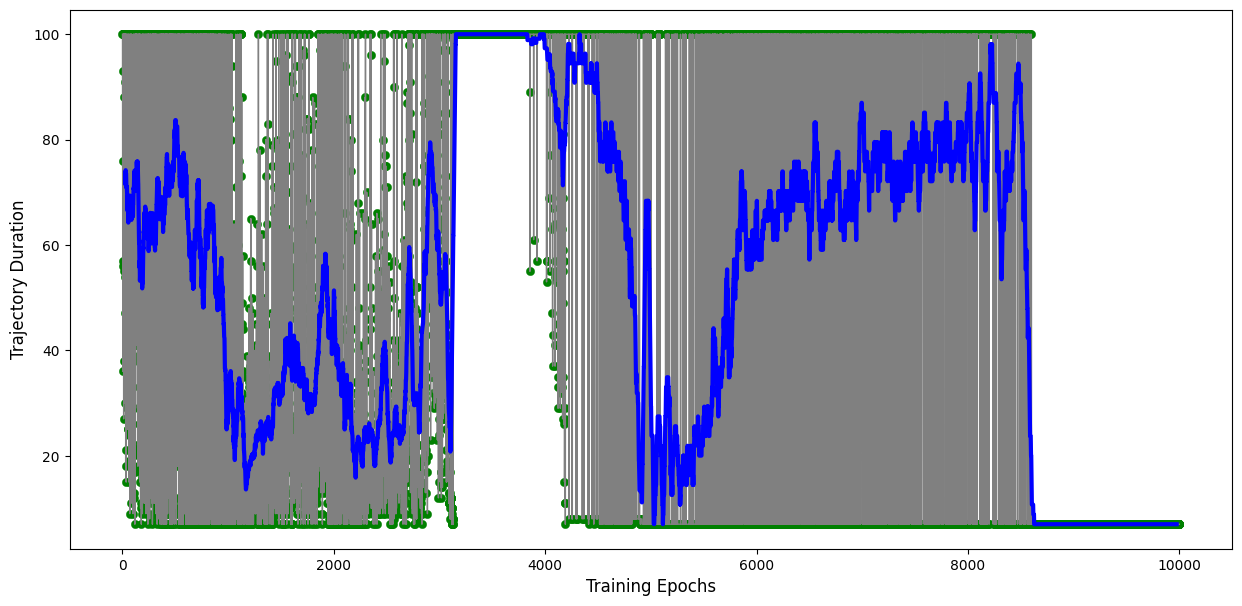

In [21]:
def running_mean(x):
    N=50
    kernel = np.ones(N)
    conv_len = x.shape[0]-N
    y = np.zeros(conv_len)

    shift = int(N/2)
    for i in range(shift, conv_len + shift):
        y[i - shift] = kernel @ x[i-shift:i+shift]
        y[i - shift] /= N
    return y

score = np.array(score)
avg_score = running_mean(score)

plt.figure(figsize=(15,7))
plt.ylabel("Trajectory Duration",fontsize=12)
plt.xlabel("Training Epochs",fontsize=12)
plt.plot(score, color='gray' , linewidth=1)
plt.plot(np.arange(25, 25 + len(avg_score)), avg_score, color='blue', linewidth=3)
plt.scatter(np.arange(score.shape[0]),score, 
            color='green' , linewidth=0.3)
plt.show()

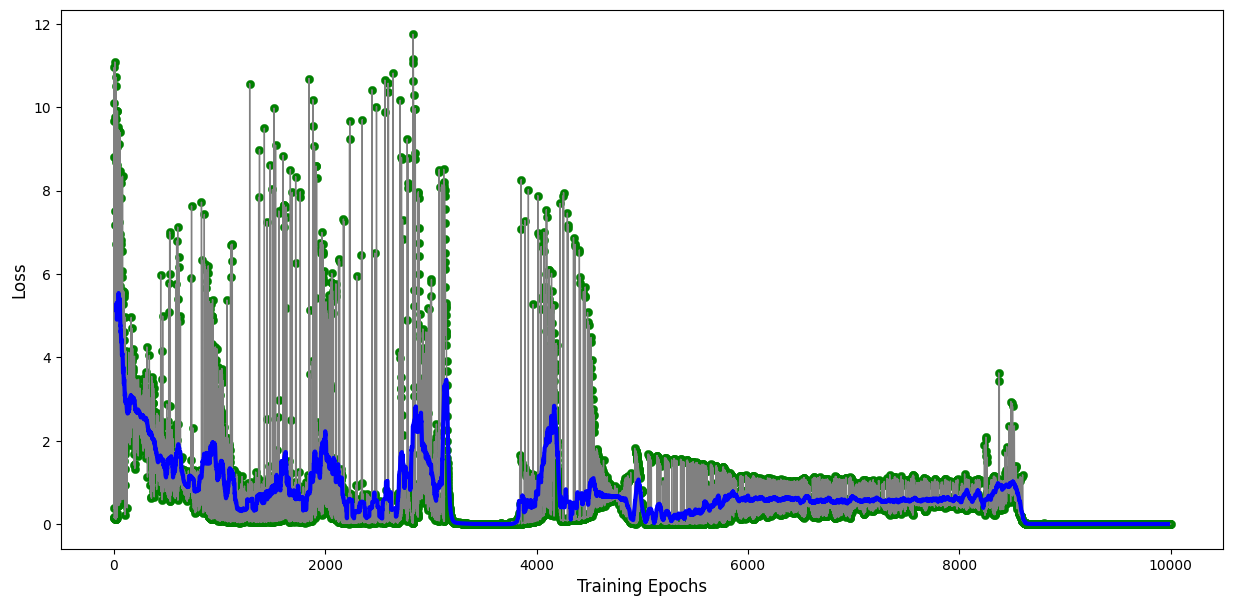

In [22]:
def running_mean(x):
    N=50
    kernel = np.ones(N)
    conv_len = x.shape[0]-N
    y = np.zeros(conv_len)

    shift = int(N/2)
    for i in range(shift, conv_len + shift):
        y[i - shift] = kernel @ x[i-shift:i+shift]
        y[i - shift] /= N
    return y

score = np.array(losses)
avg_score = running_mean(score)

plt.figure(figsize=(15,7))
plt.ylabel("Loss",fontsize=12)
plt.xlabel("Training Epochs",fontsize=12)
plt.plot(score, color='gray' , linewidth=1)
plt.plot(np.arange(25, 25 + len(avg_score)), avg_score, color='blue', linewidth=3)
plt.scatter(np.arange(score.shape[0]),score, 
            color='green' , linewidth=0.3)
plt.show()

In [23]:
torch.save(model.state_dict(), "some_model13.pt")

In [43]:
def decompose(curr_state):
    return np.array([curr_state[0][0][0], curr_state[0][0][1], curr_state[0][1][0], curr_state[0][1][1],
                     curr_state[1][0][0], curr_state[1][0][1], curr_state[1][1][0], curr_state[1][1][1],
                     curr_state[2][0], curr_state[2][1]])


def evaluate_model(model, env):
    Horizon = 100
    indexes = env.objects_indexes
    # print(indexes)
    done = False
    transitions = []
    curr_states = [decompose(env.get_state(i)) for i in indexes]
    temp = 1 /100
    s = 0

    for t in range(Horizon):
        s = t
        unstable_indexes = env.get_unstable_indexes()
        # print(unstable_indexes)
        index = unstable_indexes[random.randint(0, len(unstable_indexes) - 1)]
        # print(index)

        act_prob = model(torch.from_numpy(curr_states[index - 1]).float())
        # print(act_prob)

        l = []
        for i in [0,1,2,3]:
            if env.validate_move((index, i)):
                l.append(i)
        probs = (act_prob).data.numpy()
        
        action = np.random.choice(l, # U R D L
                p=scipy.special.softmax(probs[l]/temp, axis=0))

        labels = ['U', 'R', 'D', 'L']

        # print(l)
        # print(action)
        transitions.append((index, labels[action], probs[action]))

        env.make_move((index, action))
        curr_state = env.get_state(index)
        curr_states[index - 1] = decompose(curr_state)
        done = env.get_reward()[1]
        if done:
            break

    print(s+1)
    print(transitions)
    print()
    env.visualize_environment()
    return transitions


def complete_task(path_to_infile, path_to_outfile):
    infile = open(path_to_infile, "r")

    grid = []
    for line in infile.readlines():
        grid.append([element for element in line.split()])
    infile.close()

    if not grid:
        print("File is empty")
        sys.exit(1)

    world = GridWorld(grid)
    model = MyModel()
    model.load_state_dict(torch.load('some_model13.pt'))
    answer = evaluate_model(model, world)
    # outfile = open(path_to_outfile, "w")
    # for elem in answer:
    #     outfile.write(str(elem[0])+' '+elem[1]+"\n")
    # outfile.close()


complete_task(INPUT, OUTPUT)


7
[(1, 'L', 3.8299751), (1, 'U', 3.952959), (1, 'L', 3.8823426), (1, 'U', 3.8154106), (1, 'L', 3.8674896), (1, 'U', 3.004263), (1, 'L', 1.999066)]

[['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0']
 ['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0']
 ['0' '0' '0' 'r' '1' '1' '0' '0' '0' '0' '0' '0' '0' '0' '0']
 ['0' '0' '0' 'r' '1' '1' '0' '0' '0' '0' '0' '0' '0' '0' '0']
 ['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0']
 ['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0']
 ['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0']
 ['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0']
 ['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0']]


In [31]:
complete_task("input4.txt", OUTPUT)

6
[(1, 'U', 4.117821), (1, 'U', 3.9453006), (1, 'L', 4.0002794), (1, 'L', 3.7820172), (1, 'U', 3.21457), (1, 'L', 2.8629591)]

[['0' '0' '0' '0' '0']
 ['0' '1' '0' '0' '0']
 ['0' '0' '0' '0' '0']
 ['0' '0' '0' '0' '0']
 ['0' '0' '0' '0' '0']]
